# Project 2: Panoramic Image Stitching

This is Project 2 for [UW CSE P576 Computer Vision](https://courses.cs.washington.edu/courses/csep576/18sp). 

**Getting Started:** You should complete **[Project 1](https://courses.cs.washington.edu/courses/csep57
6/18sp/projects/Project1.html "Project 1")** first (you will need interest points and descriptors from this project). The source files for both projects are [here](https://courses.cs.washington.edu/courses/csep576/18sp/projects/project12/project12.zip "Project 1 and 2 Source Files"). To run the project locally you will need IPython/Jupyter installed, e.g., see instructions at http://jupyter.org/install.html. Launch Jupyter and open `Project2.ipynb`. Alternatively, you can import the standalone version of the notebook into [Colaboratory](https://colab.research.google.com "Colab") and run it without installing anything. Use File->Upload Notebook in Colab and open the notebook in `standalone/Project2s.ipynb`.

**This project:** In this project you will implement a panoramic image stitcher. This will build on the interest points and descriptors developed in Project 1. You'll begin with geometric filtering via RANSAC, then estimate pairwise rotations and chain these together to align the panorama. When you have a basic stitcher working, improve it with better alignment, blending, or other new features and document your findings.

**What to turn in:** Turn in a pdf of your completed ipynb notebook as well as the source .ipynb and any source .py files that you modified. Clearly describe any enhancements or experiments you tried in your ipynb notebook. If you used separate .py files, please copy/paste them at the end of the notebook before generating the pdf. Put everything in a single flat zipfile and upload via the link given in the discussion group.

`version 041618`

In [4]:
import numpy as np
import scipy.linalg
import os.path
from time import time
import types
import matplotlib.pyplot as plt

import im_util
import interest_point
import ransac
import geometry
import render
import panorama

%matplotlib inline
# edit this line to change the figure size
plt.rcParams['figure.figsize'] = (16.0, 10.0)
# force auto-reload of import modules before running code 
%load_ext autoreload
%autoreload 2

### Image Warping Test

The code below warps an image using a 3x3 transformation matrix. Experiment with the matrix P to test some of the different 2D transformations described in class, e.g., similarity, affine and projective transforms.

(-0.5, 567.5, 757.5, -0.5)

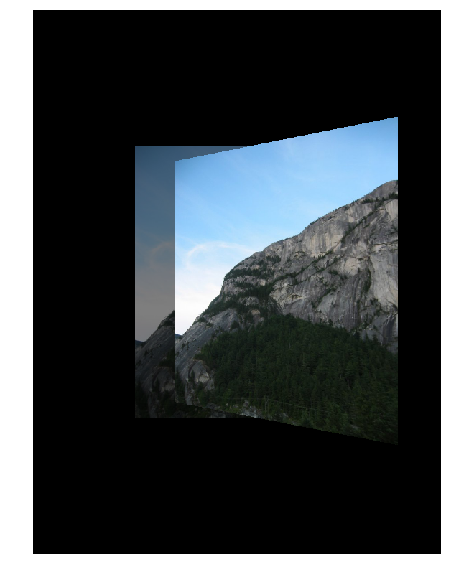

In [5]:
# read image
image_dir='data/test'
im_filename1=image_dir+'/100-0038_img.jpg'
im=im_util.image_open(im_filename1)
im_rows,im_cols,_=im.shape

# set transformation matrix
P=[[1, 0.2, -64],
  [ 0, 1.1, -120],
  [ 0, 5.2e-4, 0.83]]

# warp coordinates
r0,r1=-im_rows/2, im_rows*3/2
c0,c1=-im_cols/2, im_cols*3/2
warp_rows, warp_cols=im_rows, im_cols

coords=im_util.coordinate_image(warp_rows,warp_cols,r0,r1,c0,c1)
coords_t=im_util.transform_coordinates(coords, P)

# visualise result
warp_im1=im_util.warp_image(im,coords)
warp_im2=im_util.warp_image(im,coords_t)
alpha=im_util.warp_image(np.ones((im_rows,im_cols,1)),coords_t)
result_im=warp_im2*alpha + 0.5*warp_im1*(1-alpha)

ax1=plt.subplot(1,1,1)
plt.imshow(result_im)
plt.axis('off')

### Interest Points Test

We will use the interest points and descriptors implemented in [Project 1](https://courses.cs.washington.edu/courses/csep576/18sp/projects/Project1.html "Project 1"). If you had trouble getting these to work, contact your TA.

Run the two code blocks below to check your interest points and descriptors are working. For subsequent steps to run well, you should aim for about 100-1000 interest points.

In [6]:
"""
Read a pair of input images and convert to grey
"""
image_dir='data/test'
#im_filename1=image_dir+'/100-0023_img.jpg'
#im_filename2=image_dir+'/100-0024_img.jpg'
im_filename1=image_dir+'/100-0038_img.jpg'
im_filename2=image_dir+'/100-0039_img.jpg'

im1 = im_util.image_open(im_filename1)
im2 = im_util.image_open(im_filename2)

img1 = np.mean(im1, 2, keepdims=True)
img2 = np.mean(im2, 2, keepdims=True)

#optionally plot images
#ax1,ax2=im_util.plot_two_images(im1, im2)

"""
Find interest points in the image pair
"""
print('[ find interest points ]')
t0=time()
ip_ex = interest_point.InterestPointExtractor()
ip1 = ip_ex.find_interest_points(img1)
print(' found '+str(ip1.shape[1])+' in image 1')
ip2 = ip_ex.find_interest_points(img2)
print(' found '+str(ip2.shape[1])+' in image 2')
t1=time()
print(' % .2f secs ' % (t1-t0))

# optionally draw interest points
#print('[ drawing interest points ]')
#ax1,ax2=im_util.plot_two_images(im1,im2)
#interest_point.draw_interest_points_ax(ip1, ax1)
#interest_point.draw_interest_points_ax(ip2, ax2)

[ find interest points ]
maxima size: 183
 found 183 in image 1
maxima size: 230
 found 200 in image 2
  48.47 secs 


[ extract descriptors ]
  0.03 secs
[ match descriptors ]
  0.01 secs
[ drawing matches ]
  0.44 secs


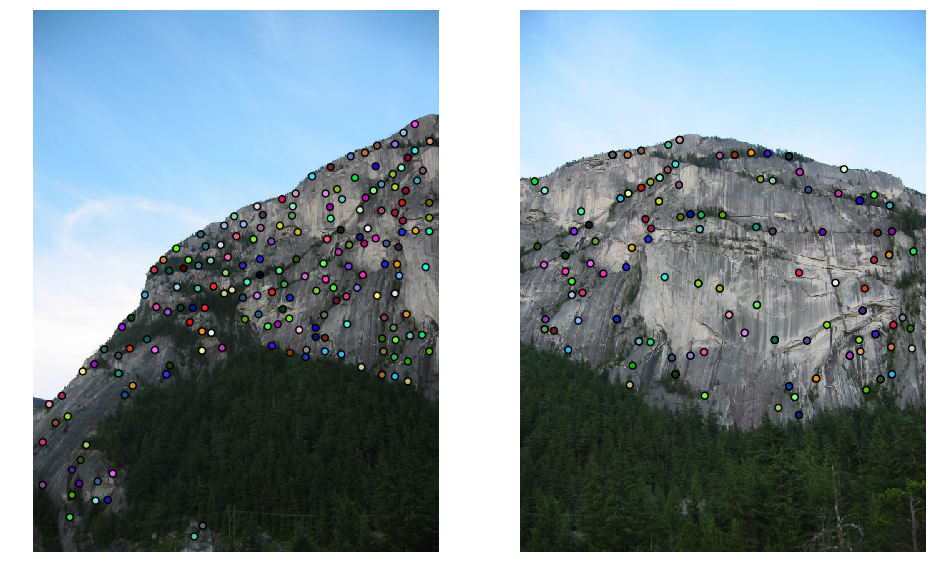

In [7]:
"""
Extract and match descriptors
"""
print('[ extract descriptors ]')
t0=time()
desc_ex = interest_point.DescriptorExtractor()
desc1 = desc_ex.get_descriptors(img1, ip1)
desc2 = desc_ex.get_descriptors(img2, ip2)
t1=time()
print(' % .2f secs' % (t1-t0))

print('[ match descriptors ]')
t0=time()
match_idx = desc_ex.match_descriptors(desc1, desc2)
t1=time()
print(' % .2f secs' % (t1-t0))

ipm=ip2[:,match_idx]

print('[ drawing matches ]')
t0=time()
ax1,ax2=im_util.plot_two_images(im1,im2)
interest_point.draw_matches_ax(ip1, ipm, ax1, ax2)
t1=time()
print(' % .2f secs' % (t1-t0))

## RANSAC Implementation

We will now use RANSAC to find consistent matches.

### Consistency Test [15%]

First we will implement a test to count the number of matches consistent with a Similarity transform. The code below generates a random Similarity transform S and a random set of points x. It then transforms the points and adds noise, and checks to see how many of these points are consistent with the ground truth transformation S.

Open `ransac.py` and implement the function `consistent`. You should find a high fraction (~80% or more) points are consistent with the true Similarity transform S when running the code below.  

In [8]:
"""
Test RANSAC functions using synthetic data
"""
# make a random S matrix
sd_pos=100
sd_angle=np.pi
theta=np.random.randn()*sd_angle
tx=np.random.randn()*sd_pos
ty=np.random.randn()*sd_pos
ct=np.cos(theta)
st=np.sin(theta)
S=[[ct,st,tx],[-st,ct,ty],[0,0,1]]

# generate random points
num_points=100
sd_points=20
x = np.random.randn(2,num_points)*sd_points
xh = geometry.hom(x)

# transform points and add noise
sd_noise=5
yh = np.dot(S, xh)
y = geometry.unhom(yh)
yn = y + np.random.randn(2,num_points)*sd_noise

print('[ Test of consistent ]')
rn = ransac.RANSAC()
inliers0=rn.consistent(S,x,yn)
num_consistent=np.sum(inliers0)
print(' number of points consistent with true S = '+str(num_consistent))
if (num_consistent > 0.75*num_points):
    print(' consistency check is working!')

[ Test of consistent ]
 number of points consistent with true S = 91
 consistency check is working!


### Similarity Solver [20%]

Now select a sample of 2 point corresondences and compute the Similarity transform corresponding to this pair. Implement `compute_similarity` in `ransac.py` and run the code below to compute the number of inliers. Try varying the indices of the sample to see how the number of inliers varies. Are there any degenerate cases? How could these be detected?

In [9]:
print('[ Test of compute_similarity ]')
sample=[0,1]
S1=rn.compute_similarity(x[:,sample],yn[:,sample])
inliers1=rn.consistent(S1,x,yn)
num_consistent=np.sum(inliers1)
print(' number of points consistent with sample S = '+str(num_consistent))

[ Test of compute_similarity ]
 number of points consistent with sample S = 4


### RANSAC Loop [15%]

Finally, finish the implementation of RANSAC by completing `ransac_similarity` in `ransac.py`. When completed you should find most of the points are labelled consistent.

In [13]:
print('[ Test of ransac_similarity ]')
S2, inliers2=rn.ransac_similarity(x, yn)
num_consistent=np.sum(inliers2)
print(' number of points consistent with ransac S = '+str(num_consistent))
if (num_consistent > 0.75*num_points):
    print(' ransac succeeded!')

[ Test of ransac_similarity ]
 number of points consistent with ransac S = 92
 ransac succeeded!


We'll now move away from our synthetic test data and run the same code on the interest point matches obtained using the input image pair above. Review the code below and check that the output looks reasonable. You should see a good set of geometrically consistent matches.

[ do ransac ]
 found 37 matches
  21.04 secs
[ drawing matches ]
  0.21 secs


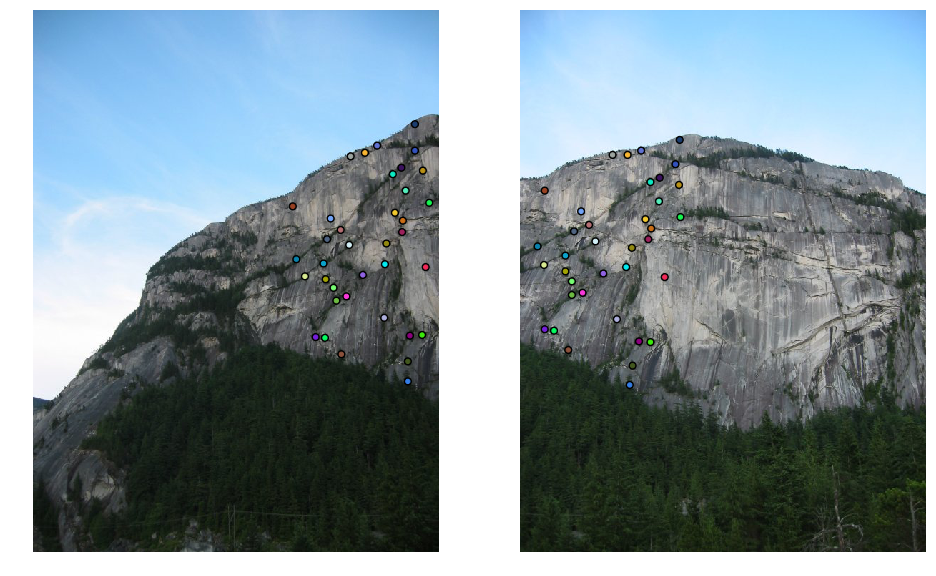

In [14]:
"""
Perform RANSAC on interest point matches
"""
print('[ do ransac ]')
t0=time()
rn = ransac.RANSAC()
S, inliers = rn.ransac_similarity(ip1,ipm)
t1=time()
num_inliers_s = np.sum(inliers)
print(' found '+str(num_inliers_s)+' matches')
print(' % .2f secs' % (t1-t0))

ip1c = ip1[:, inliers]
ipmc = ipm[:, inliers]

print('[ drawing matches ]')
t0=time()
ax1,ax2=im_util.plot_two_images(im1,im2)
interest_point.draw_matches_ax(ip1c, ipmc, ax1, ax2)
t1=time()
print(' % .2f secs' % (t1-t0))

# optionally plot descriptors for matched points
#inlier_id=np.flatnonzero(inliers)
#match_id=match_idx[inlier_id]
#interest_point.plot_matching_descriptors(desc1,desc2,inlier_id,match_id,plt)

### Rotation Estimation [15%]

The next task is to estimate the true rotation between the images. To do this, we'll take a guess at the field of view of our input images, and use a closed form algorithm to estimate the rotation. Open `geometry.py` and complete the implementation of `compute_rotation`. You should find that a large number of the matches are consistent with your rotation, and the pairwise warped images should look sensible. Try experimenting with the field of view parameter. What is the best field of view for these images? 

In [43]:
"""
Estimate rotation matrix by least squares
"""
print('[ estimate rotation ]')
t0=time()
# Note: assume field of view of 45 degrees
fov_degrees=45
print(' assuming fov='+str(fov_degrees))
K1 = geometry.get_calibration(im1.shape, fov_degrees)
K2 = geometry.get_calibration(im2.shape, fov_degrees)
R,H = geometry.compute_rotation(ip1c, ipmc, K1, K2)

num_inliers_r = np.sum(rn.consistent(H, ip1, ipm))
print(' num consistent with rotation = '+str(num_inliers_r))
if (num_inliers_r>0.9 * num_inliers_s):
    print(' compute rotation succeeded!')
t1=time()
print(' % .2f secs' % (t1-t0))
    
print('[ test pairwise warp ]')
t0=time()
im1_w, im2_w = render.pairwise_warp(im1, im2, H)
_= im_util.plot_two_images(0.5*(im1+im2_w), 0.5*(im2+im1_w))
t1=time()
print(' % .2f secs' % (t1-t0))

[ estimate rotation ]
 assuming fov=45
[[ 0.19672412  0.15956512  0.21530362  0.1387998   0.27322794  0.17486588
   0.17268006  0.22951147  0.09180459  0.13333524  0.22732565  0.24262641
   0.13661397  0.25246262  0.28524997  0.19344538  0.25464844  0.27322794
   0.10491953  0.15300765  0.25355553  0.23934768  0.26557756  0.16065803
   0.16830841  0.22623274  0.26229883  0.28962162  0.28415706  0.13552106
   0.08634003  0.148636    0.29508618  0.12131321  0.14426435  0.25902009
   0.26229883]
 [-0.19672412 -0.07868965 -0.20765324 -0.06448179 -0.24044059 -0.19125956
  -0.0557385  -0.05792432 -0.03388026 -0.02732279 -0.02622988 -0.10491953
  -0.00327874 -0.17377297 -0.16940132 -0.00983621 -0.0928975  -0.20000285
  -0.00765038  0.02950862 -0.07541091 -0.16393677  0.08306129  0.111477
   0.02295115  0.0557385   0.12240612 -0.02185824  0.08196838  0.08634003
  -0.11475574  0.00983621 -0.1202203   0.08524712 -0.09617624 -0.1387998
   0.15300765]
 [ 1.          1.          1.          1.     

LinAlgError: Last 2 dimensions of the array must be square

The following code renders the aligned images in a spherical coordinate system. Check that the images are well aligned.

In [ ]:
"""
Render 2 images in spherical coordinates
"""
images=[im1,im2]
P1=K1
P2=np.dot(K2,R)
P_matrices=[P1,P2]

render_params={}
render_params['render_width']=800
render_params['theta_min']=-45
render_params['theta_max']=45
render_params['phi_min']=-30
render_params['phi_max']=30

print ('[ render aligned images ]')
t0=time()
pano_im=render.render_spherical(images, P_matrices, render_params)
t1=time()
print(' % .2f secs' % (t1-t0))

plt.plot()
plt.imshow(pano_im)
plt.axis('off')

Let's add more images! The method `PanormaStitcher` class in `panorama.py` takes a set of images as input and wraps the interest point and matching code in the method `match_images`. Take a look at this function and test it on a set of images using the code below.

In [ ]:
"""
Read a set of input images
"""

print('[ read images ]')
image_dir='data/test'
im_filenames=os.listdir(image_dir)
im_filenames=[image_dir+'/'+fname for fname in im_filenames]

#im_filenames=[]
#im_filenames.append(image_dir+'/100-0023_img.jpg')
#im_filenames.append(image_dir+'/100-0024_img.jpg')
#im_filenames.append(image_dir+'/100-0038_img.jpg')
#im_filenames.append(image_dir+'/100-0039_img.jpg')

images=[]
for fname in im_filenames:
  images.append(im_util.image_open(fname))

"""
Stitch images
"""
stitch_params={}
stitch_params['fov_degrees']=45

num_images = len(im_filenames)
print(' stitching '+str(num_images)+' images')

pano=panorama.PanoramaStitcher(images, stitch_params)
pano.match_images()

print(' num_matches=')
print(pano.num_matches)

### Panorama Alignment [15%]

Now write code to compute a rotation matrix for each image (the first image is assumed to be the identity rotation) by chaining together pairwise rotations. The code for this should go in `align_panorama` in `panorama.py`.

You can now use the `render` method to stich all images in spherical coordinates, as shown in the code below. 

In [ ]:
pano.align_panorama()

render_params={}
render_params['render_width']=800
render_params['theta_min']=-45
render_params['theta_max']=45
render_params['phi_min']=-30
render_params['phi_max']=30

pano_im = pano.render(render_params)

plt.plot()
plt.imshow(pano_im)
plt.axis('off')

### Testing and Improving the Panorama Stitcher [20%]

You should now have a complete implementation of a basic panorama stitcher. Try it out using a few different image sets and make a note of any issues/artifacts in the results. How could the results be improved? Write a list of possible improvements, and think of new features you might like to add. Now implement some of these improvements / new features and document your work in the notebook below.

In [ ]:
### TODO your improvements to the panorama stitcher





*If you used separate .py files (i.e., not the standalone version), please copy/paste your completed `ransac.py`, `geometry.py` and `panorama.py` in the spaces below before generating your final pdf.*

### ransac.py

### geometry.py

### panorama.py 